## Defining currents based on our definitions, and some exploratory plots along the way.

In [1]:
# %matplotlib qt
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

from shapely.geometry import Polygon, Point, box
from shapely.ops import unary_union

from scipy.interpolate import griddata
from salishsea_tools import unit_conversions
from salishsea_tools import psu_tools
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

IOPATH = '/ocean/ghoeven/MOAD/Data/PNWCurrent_obs.csv'

In [2]:
ds = xr.open_dataset("/ocean/ghoeven/MOAD/Data/gebco_2023.nc")

In [3]:
obs = pd.read_csv(IOPATH)
obs['current'] = np.nan

grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')

In [4]:
# Salish Sea cuttoff
x = np.linspace(-130,-122,10)
m = -0.83
b = 48.4-(-124.6)*m

ind = np.where(obs['longitude (degrees_east)'] > (obs['latitude (degrees_north)']-b)/m) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [5]:
# 500m Depth cuttoff
# for the sake of looking at what ACTUALLY gets into the salish sea, can cuttoff at 500 m
# this reasonning is that the CC flows in the top 500, and the CUC core is around 200 m

ind = np.where(obs['depth (m)'] > 500) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)



In [6]:
# Lat and lon cuttoff
xlim, ylim = [-145.5, -120.2], [30, 60]

ind = np.where(obs['latitude (degrees_north)'] > ylim[1]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['latitude (degrees_north)'] < ylim[0]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['longitude (degrees_east)'] > xlim[1]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['longitude (degrees_east)'] < xlim[0]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [7]:
# Remove Washington Dept of Ecology and ONC data as they consist of river and salish sea data (not offshore so not relevant)
ind = np.where(obs['source'] == 'department of ecology') 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)
ind = np.where(obs['source'] == 'onc') 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [8]:
for s in set(obs.source):
    print(s)
    print(len(obs[obs.source==s]))
    print('\n')

ios ctd profiles
12148


NCEI Salish
306


ios mooring, ios bottle
9


OCNMS
42171


GEOTRACES
66


NCEI PNW
893


NCEI Coastal, NHL
10


ios bottle, GEOTRACES
18


CALCOFI
196352


ios mooring
164635


ios ctd profiles, ios bottle
51


ios bottle, NCEI PNW, GEOTRACES
3


ooi
34258


ios bottle
79501


NCEI Coastal
5644


ios bottle, NCEI PNW
400


NHL
400767




Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #471 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

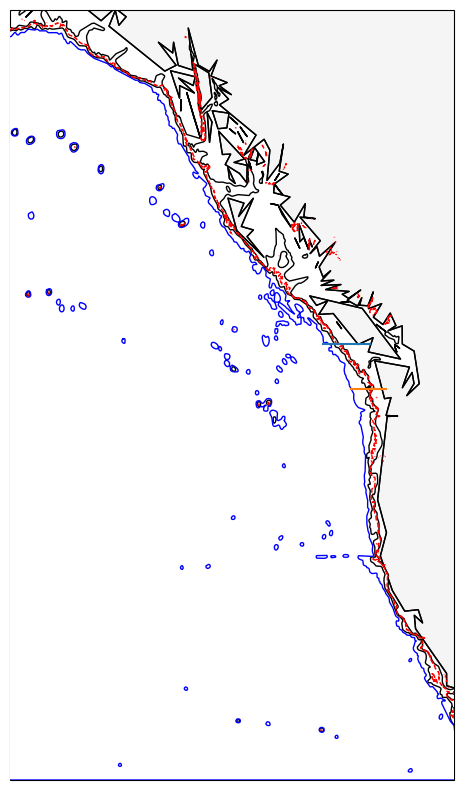

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='b',zorder=4))

elev = ds.elevation
mask = ~((ds.lon > -124.5) & (ds.lon < -122.0) & (ds.lat > 47.5) & (ds.lat < 49.5))
elev_masked = elev.where(mask)

# Add custom 500m isobath from GEBCO
cs = ax.contour(ds.lon, ds.lat, elev_masked, levels=[-500],
                colors='r', linewidths=1, transform=crs.PlateCarree(), zorder=5)
#ax.clabel(cs, fmt='%d m', fontsize=8)

# offshore cuttoff 
# y=np.linspace(42,52,100)
# x = np.sqrt((1-((y-42)**2)/(9**2))*(6**2))-130.8
# ax.plot(x,y, transform=crs.PlateCarree(),zorder=7, c='r')

#north cuttoff
ax.plot([-127.7,-125],[49,49], transform=crs.PlateCarree(),zorder=7)

# south cuttoff
ax.plot([-126.1,-124.1],[47.3,47.3], transform=crs.PlateCarree(),zorder=7)
# south deep s>=33.9
# south shelf s>=32 <33.9
# south fresh s<32

In [10]:
# filter those offshore of the 2000 m isobar

# Load the bathymetry shapefile
bathymetry = gpd.read_file("/ocean/ghoeven/MOAD/Data/ne_10m_bathymetry_I_2000.shp")

# Filter for the 2000 m contour polygons
contour_2000m = bathymetry[bathymetry['depth'] == 2000]

contour_2000m = contour_2000m.set_crs('EPSG:4326')

# Now, ensure both GeoDataFrames are in the same CRS
obs['geometry'] = obs.apply(lambda row: Point(row["longitude (degrees_east)"], row["latitude (degrees_north)"]), axis=1)
obs_gdf = gpd.GeoDataFrame(obs, geometry='geometry', crs='EPSG:4326')  # Ensure the CRS matches bathymetry
obs_gdf = obs_gdf.to_crs(contour_2000m.crs)  # Make sure your observations match the bathymetry CRS

# Perform the spatial join or classification as before
obs_gdf['is_shelf'] = obs_gdf.within(contour_2000m.geometry.union_all())

# Apply classification based on the result of spatial join
obs_gdf['location_type'] = obs_gdf['is_shelf'].apply(lambda x: 'offshore' if x else 'shelf')

In [11]:
# # can we do the same for data between the 2000m and 500m isobar? call it "slope" data instead of "shelf"
z = ds['elevation'].values
lon = ds['lon'].values
lat = ds['lat'].values
lon2d, lat2d = np.meshgrid(lon, lat)

# Extract contours at -500m and -2000m
levels=[-2000, -500]
fig, ax = plt.subplots()
cs = ax.contour(lon2d, lat2d, z, levels=levels)
plt.close(fig)

saved_paths = []
# Loop over all levels
for level_idx, segments_at_level in enumerate(cs.allsegs):
    level_value = cs.levels[level_idx]
    for path in segments_at_level:
        if not np.allclose(path[0], path[-1]):
            # ax.plot(path[:, 0], path[:, 1], label=f'Open at {level_value}', lw=2)
            saved_paths.append(path)

# plt.show()

sorted_arrays = sorted(saved_paths, key=lambda x: x.size, reverse=True)
alongshore_contours = sorted_arrays[:2]

def connect_paths(p1, p2):
    # Extract endpoints
    ends = {
        (0, 0): np.linalg.norm(p1[0] - p2[0]),
        (0, -1): np.linalg.norm(p1[0] - p2[-1]),
        (-1, 0): np.linalg.norm(p1[-1] - p2[0]),
        (-1, -1): np.linalg.norm(p1[-1] - p2[-1]),
    }
    # Choose the shortest connection
    (i1, i2), _ = min(ends.items(), key=lambda x: x[1])

    # Reverse paths as needed
    if i1 == 0:
        p1 = p1[::-1]
    if i2 != 0:
        p2 = p2[::-1]

    # Concatenate and close
    combined = np.vstack([p1, p2, p1[0:1]])  # close the polygon
    return combined

# Use function to combine
joined_polygon = connect_paths(alongshore_contours[0], alongshore_contours[1])
poly = Polygon(joined_polygon)

# Build GeoDataFrame from the slope region
slope_gdf = gpd.GeoDataFrame(geometry=[poly], crs="EPSG:4326")

# Classify obs_gdf points as 'slope' if within region
obs_500 = obs_gdf[obs_gdf.location_type == 'shelf'].copy()
obs_500['is_slope'] = obs_500.within(poly)
obs_500['location_type'] = obs_500['is_slope'].apply(lambda x: 'slope' if x else 'shelf')

In [12]:
obs['location'] = obs_gdf['location_type']
obs.location[obs.location=='shelf'] = obs_500['location_type']

/tmp/ipykernel_3543667/2599749716.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  obs.location[obs.location=='shelf'] = obs_500['location_type']
/tmp/ipykernel_3543667/2599749716.py:2: SettingWithCopyWarning: 
A value is trying to be set

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

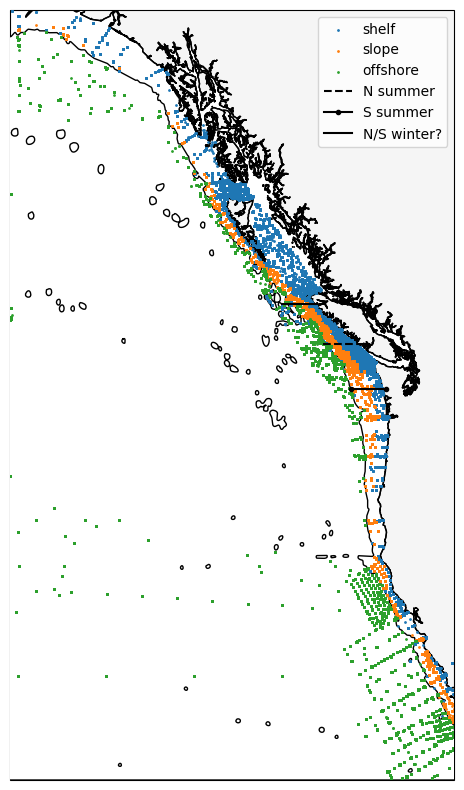

In [13]:
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'shelf'],obs['latitude (degrees_north)'][obs.location == 'shelf'], transform=crs.PlateCarree(),s=1,zorder=5,label='shelf')
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'slope'],obs['latitude (degrees_north)'][obs.location == 'slope'], transform=crs.PlateCarree(),s=1,zorder=5,label='slope')
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'offshore'],obs['latitude (degrees_north)'][obs.location == 'offshore'], transform=crs.PlateCarree(),s=1,zorder=5,label='offshore')

#cuttoffs
ax.plot([-127.7,-125],[49,49], 'k--', transform=crs.PlateCarree(),zorder=7,label='N summer')
ax.plot([-126.1,-124.1],[47.3,47.3], 'k.-', transform=crs.PlateCarree(),zorder=7,label='S summer')
ax.plot([-130,-128],[50.5,50.5], 'k', transform=crs.PlateCarree(),zorder=7,label='N/S winter?')


ax.legend()

In [14]:
# we're going to divide our watermasses differently during upwelling and downwelling
# so get month from the time

obs['time']=pd.to_datetime(obs.time)
obs['month'] = [obs.time[i].month for i in obs.index]
obs['year'] = [obs.time[i].year for i in obs.index]

In [15]:
# Seperating Shelf current 
obs['current'] = ""
poly1 = np.array([[-128.5, 50.7],
         [-127.3, 51.2],
         [-122.2, 48],
         [-124.1, 48],
         [-128.5, 50.7]])
polygon1 = Polygon(poly1)


poly2 = np.array([[-137.5, 56.7],
         [-126.3, 46.4],
         [-125, 40],
         [-145.4, 43],
         [-145.4, 56.7],
         [-137.5, 56.7]])
polygon2 = Polygon(poly2)

# Adding all points on the shelf to our overall shelf current
obs['current'][obs['location']== 'shelf'] = 'Shelf_Current'

# Removing shelf current rows that do not fulfill our minimum salinity requirements (river water)
obs = obs[~((obs['current'] == 'Shelf_Current') & (obs['salinity (g kg-1)'] < 31.5))]

# Removing shelf current rows inside inlets in Vancouver Island (polygon used here originally plotted out below)
mask = obs.apply(lambda row: polygon1.contains(Point(row['longitude (degrees_east)'], row['latitude (degrees_north)'])), axis=1)
obs = obs[~mask].reset_index(drop=True)

# Removing shelf current rows on seamounts (polygon used here originally plotted out below)
mask = obs.apply(lambda row: polygon2.contains(Point(row['longitude (degrees_east)'], row['latitude (degrees_north)'])), axis=1)
obs = obs[~mask].reset_index(drop=True)


/tmp/ipykernel_3543667/3384048920.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  obs['current'][obs['location']== 'shelf'] = 'Shelf_Current'
/tmp/ipykernel_3543667/3384048920.py:20: SettingWithCopyWarning: 
A value is trying to be set 

In [16]:
# Seperating CUC
densMin = 26.5
densMax = 26.6
depthMin = 175
depthMax = 275
obs['salinity (psu)'] = unit_conversions.teos_psu(obs['salinity (g kg-1)'])
obs['density (kg m-3)'] = psu_tools.calculate_density(obs['temperature (degC)'], obs['salinity (psu)'])-1000

# Selecting data that is on the 26.5-26.6 isopycnal and where a current is over the continental slope
mask = ((obs['density (kg m-3)'] >= densMin) # from Thomson & Krassovski 2010, Meinvielle & Johnson 2013
        & (obs['density (kg m-3)'] <= densMax) # from Thomson & Krassovski 2010, Meinvielle & Johnson 2013
        # & (obs['depth (m)'] <= depthMax) # from Thomson & Krassovski 2010
        # & (obs['depth (m)'] >= depthMin) # from Thomson & Krassovski 2010
        & (obs['latitude (degrees_north)'] < 50) # from Meinvielle & Johnson 2013
        & (obs['latitude (degrees_north)'] > 25) # from Meinvielle & Johnson 2013
        & (obs['location'] == 'slope')) # from Meinvielle & Johnson 2013
obs.loc[mask, 'current'] = 'CUC'
print(obs[mask][['depth (m)', 'density (kg m-3)', 'location']].head())
cuc_obs = obs[obs['current'] == 'CUC']
print(cuc_obs[~(cuc_obs['location'] == 'slope')])

       depth (m)  density (kg m-3) location
30866      142.0         26.518583    slope
30867      143.0         26.521357    slope
30868      145.0         26.521401    slope
30869      147.0         26.521446    slope
30870      150.0         26.529397    slope
Empty DataFrame
Columns: [Unnamed: 0.1, Unnamed: 0, time, longitude (degrees_east), latitude (degrees_north), depth (m), pressure (dbar), temperature (degC), salinity (g kg-1), DO (umol kg-1), NO3 (uM), NO2 (uM), NH4 (uM), PO4 (uM), SiO4 (uM), Chl (mg m-3), TA (uM), DIC (uM), Carbonate, Aragonite, Calcite, Cd (nmol kg-1), Co (nmol kg-1), Cu (nmol kg-1), Fe (nmol kg-1), Mn (nmol kg-1), Ni (nmol kg-1), Zn (nmol kg-1), source, Nstar (umol kg-1), spice, current, geometry, location, month, year, salinity (psu), density (kg m-3), is_offshore100, TA-DIC (uM)]
Index: []

[0 rows x 40 columns]


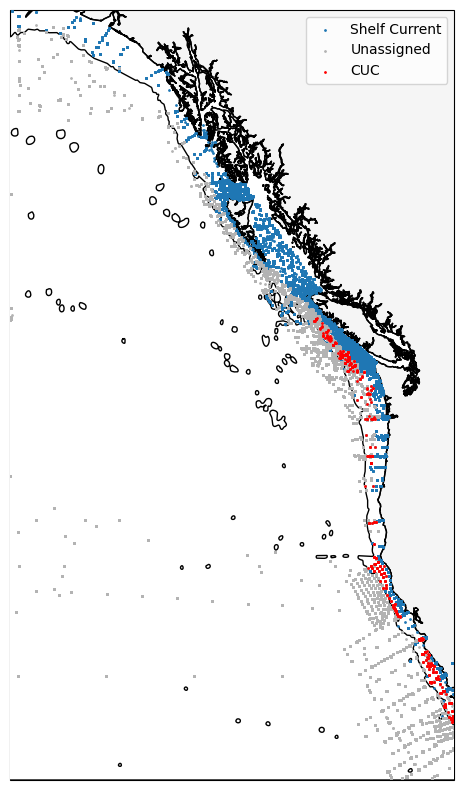

In [17]:
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'Shelf_Current'],obs['latitude (degrees_north)'][obs.current == 'Shelf_Current'], transform=crs.PlateCarree(),s=1,zorder=5,label='Shelf Current')
ax.scatter(obs['longitude (degrees_east)'][obs.current == ''],obs['latitude (degrees_north)'][obs.current == ''], c='0.7', transform=crs.PlateCarree(),s=1,zorder=5,label='Unassigned')
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'CUC'],obs['latitude (degrees_north)'][obs.current == 'CUC'], c='r', transform=crs.PlateCarree(),s=1,zorder=5,label='CUC')


#cuttoffs
# ax.plot([-127.7,-125],[49,49], 'k--', transform=crs.PlateCarree(),zorder=7,label='N summer')
# ax.plot([-126.1,-124.1],[47.3,47.3], 'k.-', transform=crs.PlateCarree(),zorder=7,label='S summer')
# ax.plot([-130,-128],[50.5,50.5], 'k', transform=crs.PlateCarree(),zorder=7,label='N/S winter?')


ax.legend()

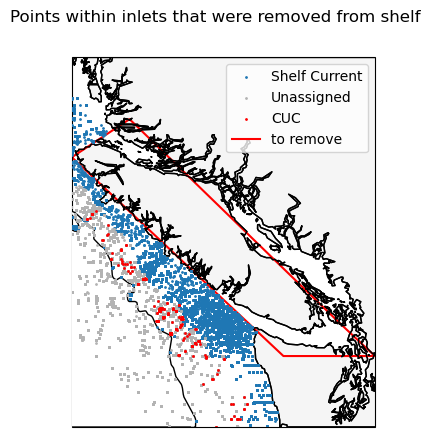

In [18]:
xlim, ylim = [-128.5, -122.2], [47, 52]

fig, ax = plt.subplots(1,1, subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'Shelf_Current'],obs['latitude (degrees_north)'][obs.current == 'Shelf_Current'], transform=crs.PlateCarree(),s=1,zorder=5,label='Shelf Current')
ax.scatter(obs['longitude (degrees_east)'][obs.current == ''],obs['latitude (degrees_north)'][obs.current == ''], c='0.7', transform=crs.PlateCarree(),s=1,zorder=5,label='Unassigned')
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'CUC'],obs['latitude (degrees_north)'][obs.current == 'CUC'], c='r', transform=crs.PlateCarree(),s=1,zorder=5,label='CUC')

poly = np.array([[-128.5, 50.7],
         [-127.3, 51.2],
         [-122.2, 48],
         [-124.1, 48],
         [-128.5, 50.7]])
ax.plot(poly[:,0], poly[:,1], c='r', transform=crs.PlateCarree(), label='to remove')

#cuttoffs
# ax.plot([-127.7,-125],[49,49], 'k--', transform=crs.PlateCarree(),zorder=7,label='N summer')
# ax.plot([-126.1,-124.1],[47.3,47.3], 'k.-', transform=crs.PlateCarree(),zorder=7,label='S summer')
# ax.plot([-130,-128],[50.5,50.5], 'k', transform=crs.PlateCarree(),zorder=7,label='N/S winter?')
plt.suptitle('Points within inlets that were removed from shelf')

ax.legend()

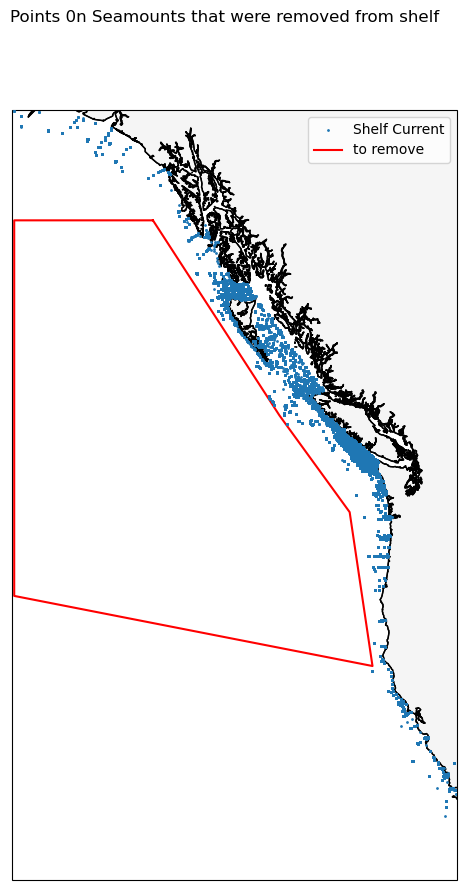

In [19]:
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'Shelf_Current'],obs['latitude (degrees_north)'][obs.current == 'Shelf_Current'], transform=crs.PlateCarree(),s=1,zorder=5,label='Shelf Current')

poly = np.array([[-137.5, 56.7],
         [-126.3, 46.4],
         [-125, 40],
         [-145.4, 43],
         [-145.4, 56.7],
         [-137.5, 56.7]])
ax.plot(poly[:,0], poly[:,1], c='r', transform=crs.PlateCarree(), label='to remove')

plt.suptitle('Points 0n Seamounts that were removed from shelf')

ax.legend()

In [20]:
obs_cuc = obs[obs["current"] == 'CUC']
obs_cuc

Unnamed: 0.1  Unnamed: 0                      time  \
30866          30866      139246 1972-05-09 00:00:00+00:00   
30867          30867      139247 1972-05-09 00:00:00+00:00   
30868          30868      139248 1972-05-09 00:00:00+00:00   
30869          30869      139249 1972-05-09 00:00:00+00:00   
30870          30870      139250 1972-05-09 00:00:00+00:00   
...              ...         ...                       ...   
936484        936484     2655402 2024-08-22 00:00:00+00:00   
936493        936493     2655424 2024-08-23 00:00:00+00:00   
936502        936502     2655447 2024-08-24 00:00:00+00:00   
936511        936511     2655470 2024-08-25 00:00:00+00:00   
936520        936520     2655492 2024-08-26 00:00:00+00:00   

        longitude (degrees_east)  latitude (degrees_north)  depth (m)  \
30866                    -126.68                     48.63      142.0   
30867                    -126.68                     48.63      143.0   
30868                    -126.68                     48.63      145.0   
30869                    -126.68                     48.63      147.0   
30870                    -126.68                     48.63      150.0   
...                          ...                       ...        ...   
936484                   -124.95                     44.37        0.0   
936493                   -124.95                     44.37        0.0   
936502                   -124.95                     44.37        0.0   
936511                   -124.95                     44.37        0.0   
936520                   -124.95                     44.37        0.0   

        pressure (dbar)  temperature (degC)  salinity (g kg-1)  \
30866         143.25955            7.098297          34.033815   
30867         144.26877            7.078301          34.033843   
30868         146.28723            7.078301          34.033900   
30869         148.30571            7.078301          34.033956   
30870         151.33347            7.078301          34.044101   
...                 ...                 ...                ...   
936484          0.00000            7.330787          34.121369   
936493          0.00000            7.386125          34.138650   
936502          0.00000            7.401760          34.117958   
936511          0.00000            7.453199          34.119421   
936520          0.00000            7.454420          34.114988   

        DO (umol kg-1)  ...     spice  current               geometry  \
30866              NaN  ... -0.037819      CUC  POINT (-126.68 48.63)   
30867              NaN  ... -0.040765      CUC  POINT (-126.68 48.63)   
30868              NaN  ... -0.040725      CUC  POINT (-126.68 48.63)   
30869              NaN  ... -0.040685      CUC  POINT (-126.68 48.63)   
30870              NaN  ... -0.033401      CUC  POINT (-126.68 48.63)   
...                ...  ...       ...      ...                    ...   
936484       93.260732  ...  0.059917      CUC  POINT (-124.95 44.37)   
936493      101.938706  ...  0.080728      CUC  POINT (-124.95 44.37)   
936502      112.628501  ...  0.068228      CUC  POINT (-124.95 44.37)   
936511      115.467806  ...  0.077114      CUC  POINT (-124.95 44.37)   
936520      116.201140  ...  0.074113      CUC  POINT (-124.95 44.37)   

        location  month  year  salinity (psu)  density (kg m-3)  \
30866      slope      5  1972       33.874084         26.518583   
30867      slope      5  1972       33.874112         26.521357   
30868      slope      5  1972       33.874168         26.521401   
30869      slope      5  1972       33.874224         26.521446   
30870      slope      5  1972       33.884322         26.529397   
...          ...    ...   ...             ...               ...   
936484     slope      8  2024       33.961227         26.554820   
936493     slope      8  2024       33.978427         26.560557   
936502     slope      8  2024       33.957832         26.542145   
936511     slope      8  2024       33.959289 

Text(0, 0.5, 'depth (m)')

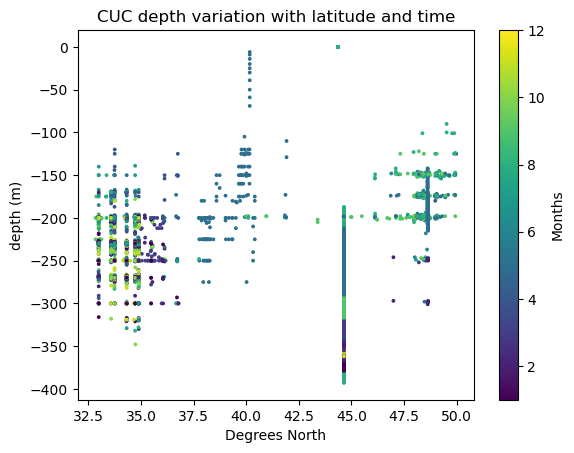

In [21]:


sc = plt.scatter(obs_cuc['latitude (degrees_north)'], -obs_cuc['depth (m)'], c=obs_cuc['month'], cmap='viridis', s=3, vmin=1, vmax=12)
plt.colorbar(sc, orientation='vertical', label='Months')
plt.title('CUC depth variation with latitude and time')
plt.xlabel('Degrees North')
plt.ylabel('depth (m)')
# sc = ax.scatter(lon0m, lat0m, transform=crs.PlateCarree(), c=chl0m, cmap='viridis', s=3, vmin=0, vmax=45)
# cbar = fig.colorbar(sc, ax=ax, orientation='vertical', label='Chlorophyll at Surface (mg m^-3)')

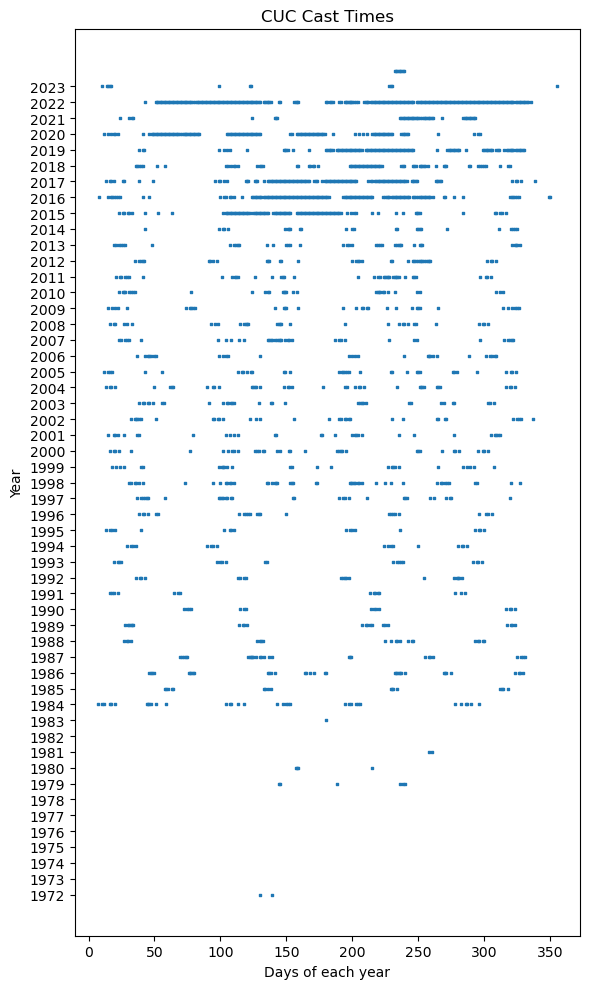

In [22]:
# plt.scatter(obs_cuc['time'], np.ones(len(obs_cuc)))

fig, ax = plt.subplots(figsize=(6, 10))

obs_cuc_dd = obs_cuc.drop_duplicates(subset='time', keep='first')

yearDay = obs_cuc_dd['time'].dt.dayofyear
year = obs_cuc_dd['time'].dt.year

ax.scatter(yearDay, year, s=2, marker='s' )
# ax.scatter(yearDay, year, s=2, marker='s', c=obs_cuc['month'], cmap='viridis')

ax.set_title('CUC Cast Times')
ax.set_yticks(range(1972, 2024))  
ax.set_ylabel('Year')
ax.set_xlabel('Days of each year')


plt.tight_layout()
plt.show()

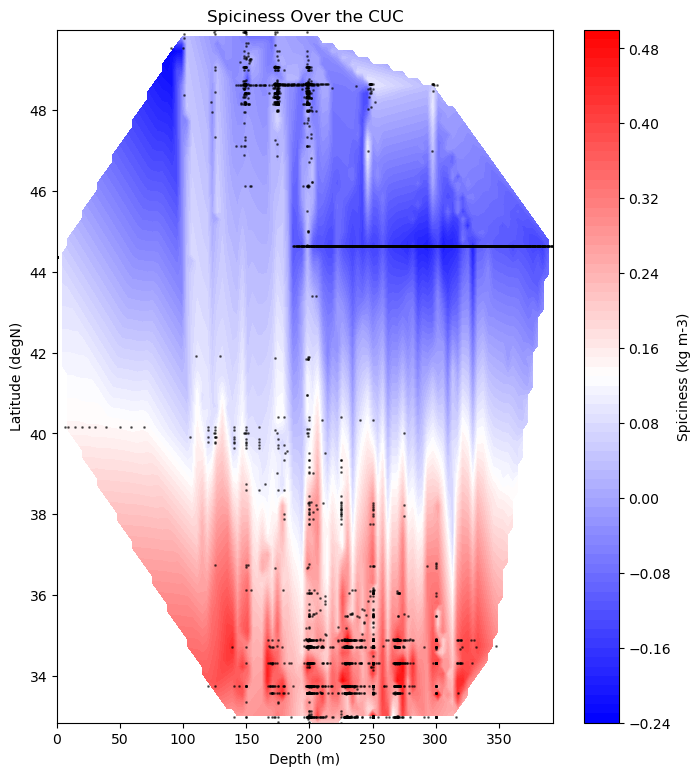

In [23]:
# Spiciness as a function of depth and latitude along CUC
x = obs_cuc['depth (m)'] 
y = obs_cuc['latitude (degrees_north)'] 
z = obs_cuc['spice']  # scalar field 

xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)

zi = griddata((x, y), z, (xi, yi), method='linear')

# Make the contour plot
plt.figure(figsize=(8, 9))
cp = plt.contourf(xi, yi, zi, levels=80, cmap='bwr')
plt.colorbar(cp, label='Spiciness (kg m-3)')
plt.scatter(x, y, s=1, c='k', alpha=0.5)
plt.xlabel('Depth (m)')
plt.ylabel('Latitude (degN)')
plt.title('Spiciness Over the CUC')
plt.show()

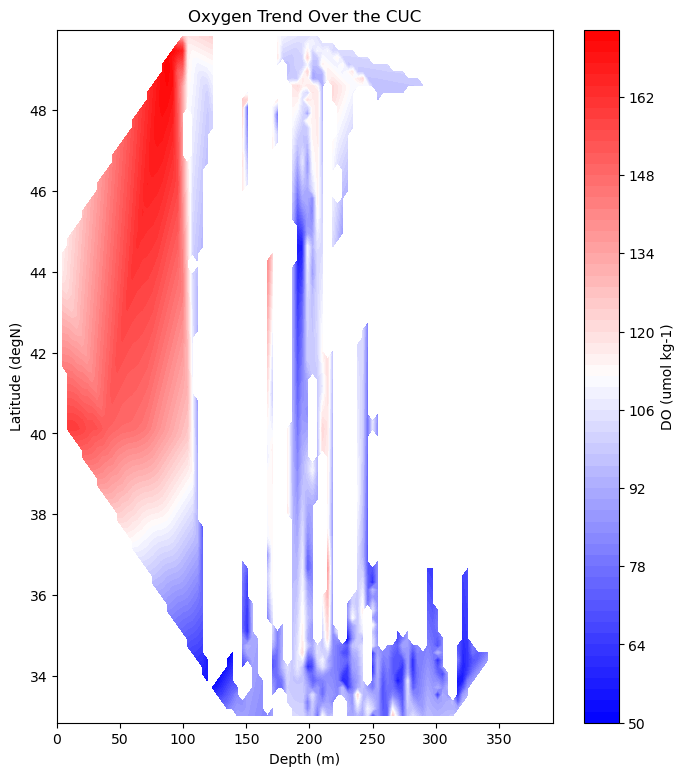

Unnamed: 0.1  Unnamed: 0                      time  \
30866          30866      139246 1972-05-09 00:00:00+00:00   
30867          30867      139247 1972-05-09 00:00:00+00:00   
30868          30868      139248 1972-05-09 00:00:00+00:00   
30869          30869      139249 1972-05-09 00:00:00+00:00   
30870          30870      139250 1972-05-09 00:00:00+00:00   
...              ...         ...                       ...   
936484        936484     2655402 2024-08-22 00:00:00+00:00   
936493        936493     2655424 2024-08-23 00:00:00+00:00   
936502        936502     2655447 2024-08-24 00:00:00+00:00   
936511        936511     2655470 2024-08-25 00:00:00+00:00   
936520        936520     2655492 2024-08-26 00:00:00+00:00   

        longitude (degrees_east)  latitude (degrees_north)  depth (m)  \
30866                    -126.68                     48.63      142.0   
30867                    -126.68                     48.63      143.0   
30868                    -126.68                     48.63      145.0   
30869                    -126.68                     48.63      147.0   
30870                    -126.68                     48.63      150.0   
...                          ...                       ...        ...   
936484                   -124.95                     44.37        0.0   
936493                   -124.95                     44.37        0.0   
936502                   -124.95                     44.37        0.0   
936511                   -124.95                     44.37        0.0   
936520                   -124.95                     44.37        0.0   

        pressure (dbar)  temperature (degC)  salinity (g kg-1)  \
30866         143.25955            7.098297          34.033815   
30867         144.26877            7.078301          34.033843   
30868         146.28723            7.078301          34.033900   
30869         148.30571            7.078301          34.033956   
30870         151.33347            7.078301          34.044101   
...                 ...                 ...                ...   
936484          0.00000            7.330787          34.121369   
936493          0.00000            7.386125          34.138650   
936502          0.00000            7.401760          34.117958   
936511          0.00000            7.453199          34.119421   
936520          0.00000            7.454420          34.114988   

        DO (umol kg-1)  ...     spice  current               geometry  \
30866              NaN  ... -0.037819      CUC  POINT (-126.68 48.63)   
30867              NaN  ... -0.040765      CUC  POINT (-126.68 48.63)   
30868              NaN  ... -0.040725      CUC  POINT (-126.68 48.63)   
30869              NaN  ... -0.040685      CUC  POINT (-126.68 48.63)   
30870              NaN  ... -0.033401      CUC  POINT (-126.68 48.63)   
...                ...  ...       ...      ...                    ...   
936484       93.260732  ...  0.059917      CUC  POINT (-124.95 44.37)   
936493      101.938706  ...  0.080728      CUC  POINT (-124.95 44.37)   
936502      112.628501  ...  0.068228      CUC  POINT (-124.95 44.37)   
936511      115.467806  ...  0.077114      CUC  POINT (-124.95 44.37)   
936520      116.201140  ...  0.074113      CUC  POINT (-124.95 44.37)   

        location  month  year  salinity (psu)  density (kg m-3)  \
30866      slope      5  1972       33.874084         26.518583   
30867      slope      5  1972       33.874112         26.521357   
30868      slope      5  1972       33.874168         26.521401   
30869      slope      5  1972       33.874224         26.521446   
30870      slope      5  1972       33.884322         26.529397   
...          ...    ...   ...             ...               ...   
936484     slope      8  2024       33.961227         26.554820   
936493     slope      8  2024       33.978427         26.560557   
936502     slope      8  2024       33.957832         26.542145   
936511     slope      8  2024       33.959289 

In [24]:
# DO as a function of depth and latitude along CUC
x = obs_cuc['depth (m)'] 
y = obs_cuc['latitude (degrees_north)'] 
z = obs_cuc['DO (umol kg-1)']  # scalar field 

xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)

zi = griddata((x, y), z, (xi, yi), method='linear')

# Make the contour plot
plt.figure(figsize=(8, 9))
cp = plt.contourf(xi, yi, zi, levels=80, cmap='bwr')
plt.colorbar(cp, label='DO (umol kg-1)')
plt.xlabel('Depth (m)')
plt.ylabel('Latitude (degN)')
plt.title('Oxygen Trend Over the CUC')
plt.show()
obs_cuc

/tmp/ipykernel_3543667/4207038761.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc_obs['cast_id'] = cc_obs.groupby(['time', "longitude (degrees_east)", "latitude (degrees_north)"]).ngroup()
/tmp/ipykernel_3543667/4207038761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc_obs.sort_values(by=['cast_id', 'depth (m)'], inplace=True)
/tmp/ipykernel_3543667/4207038761.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

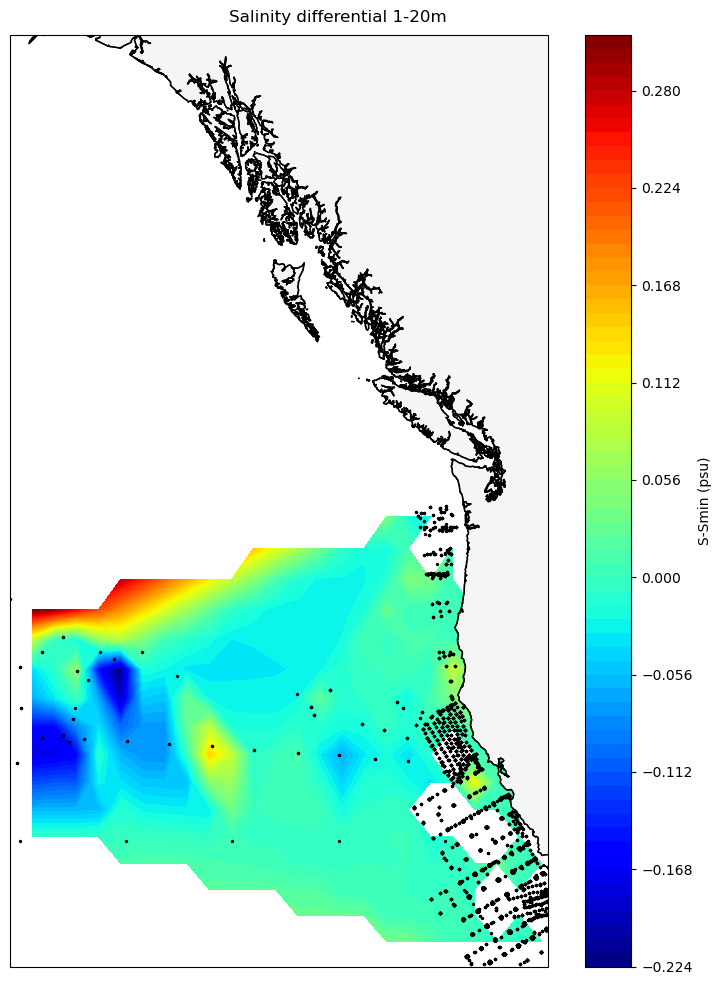

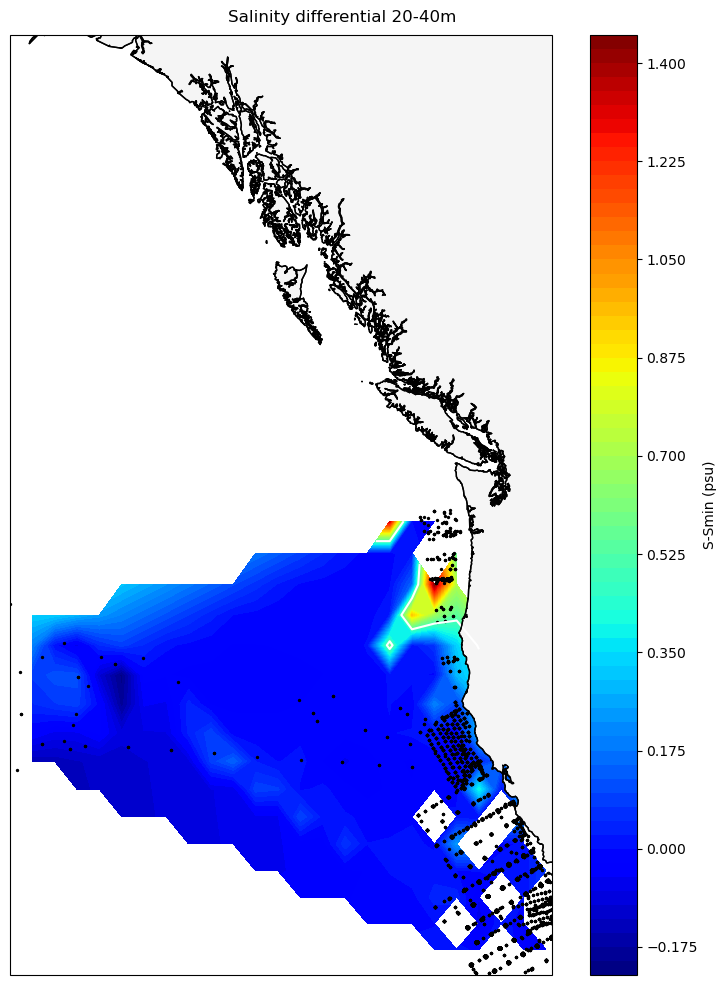

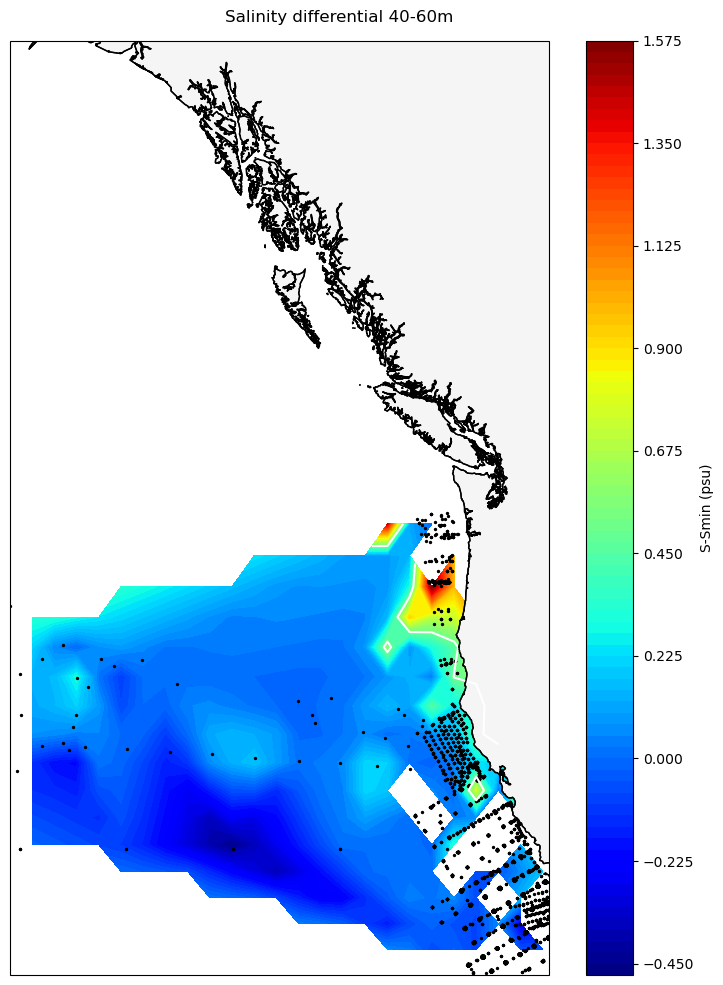

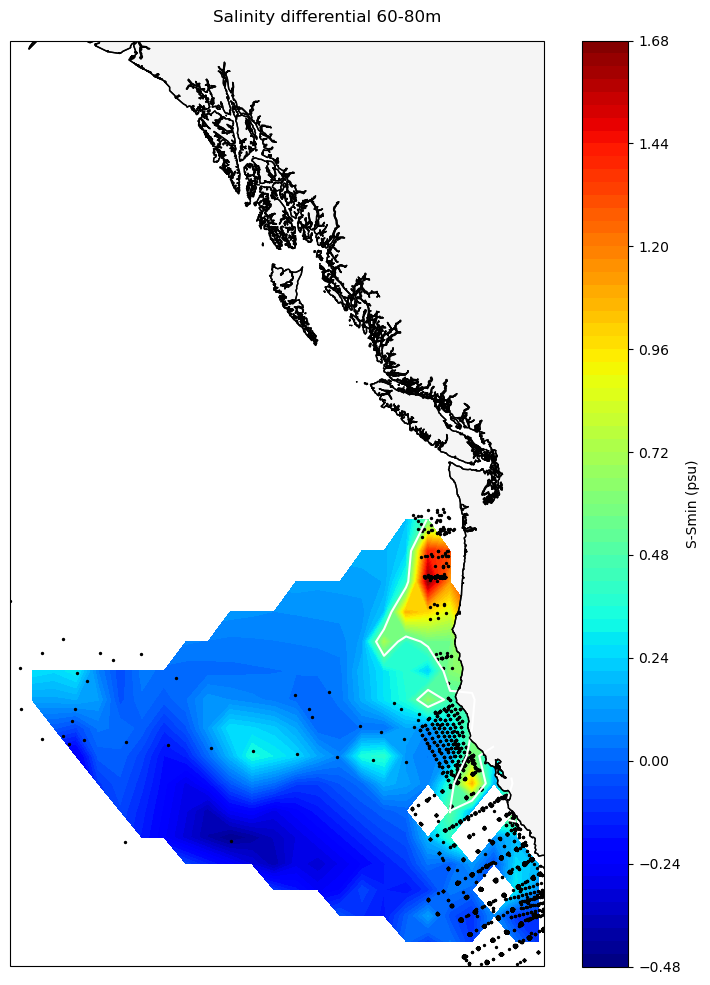

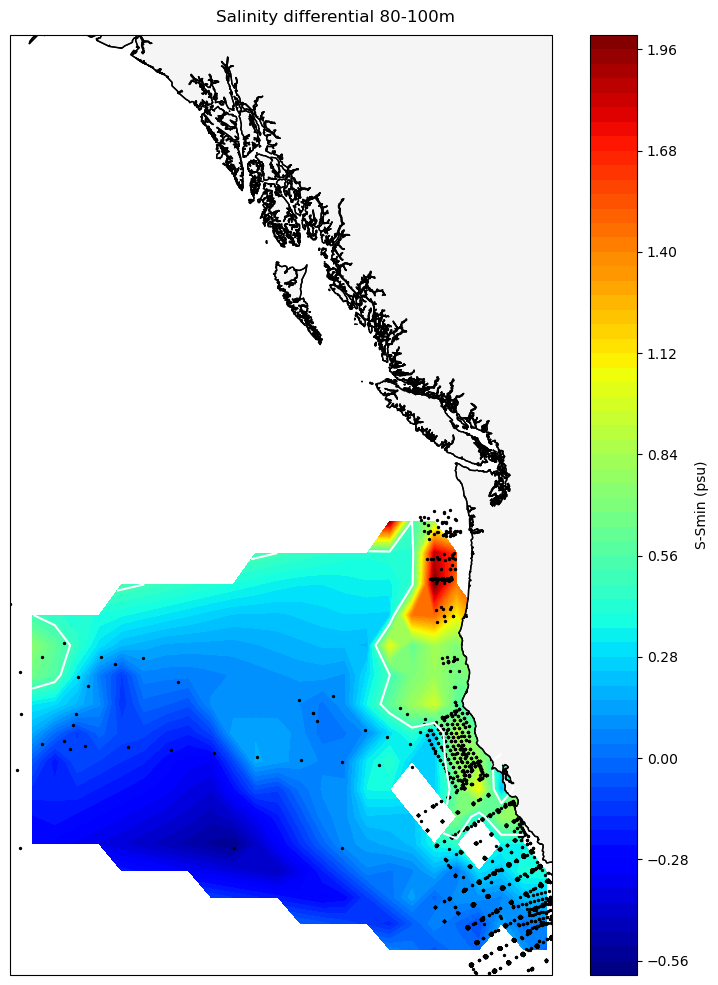

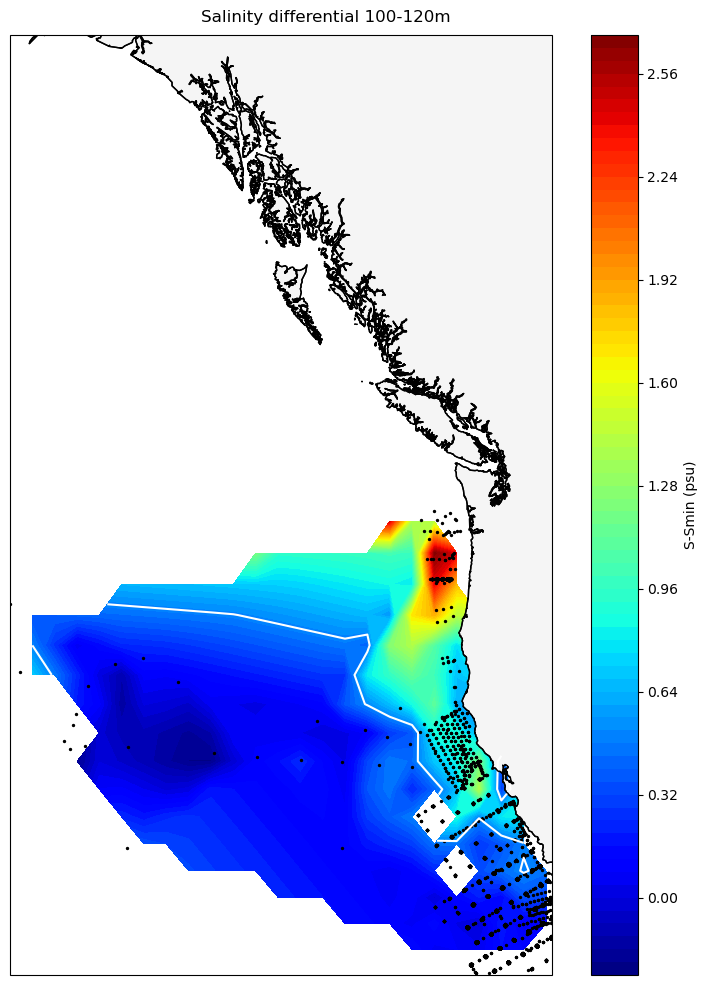

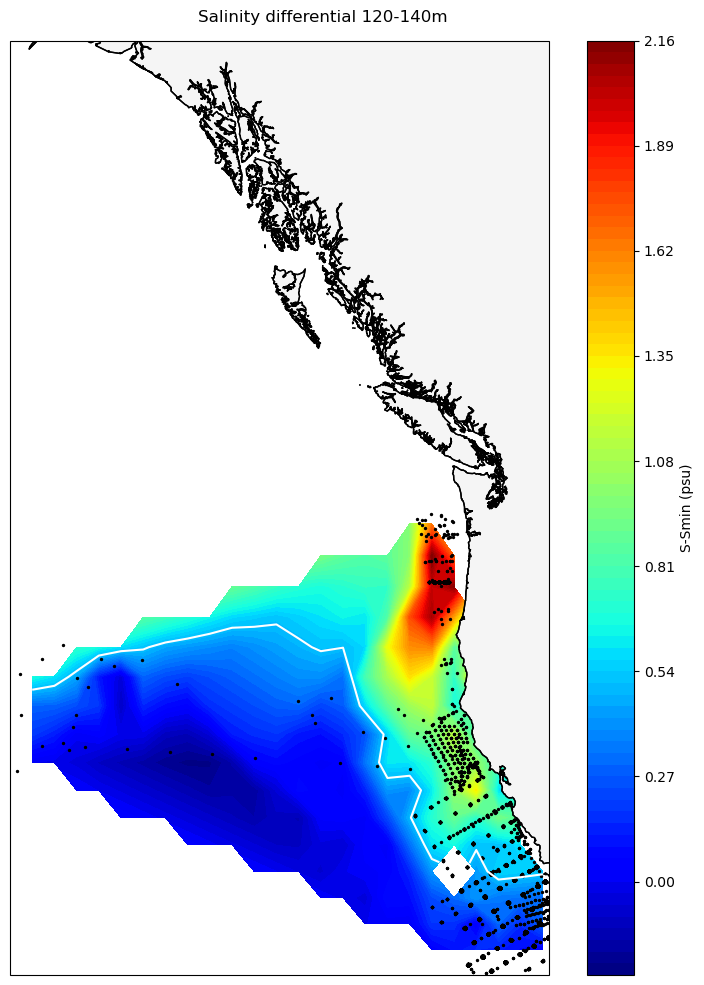

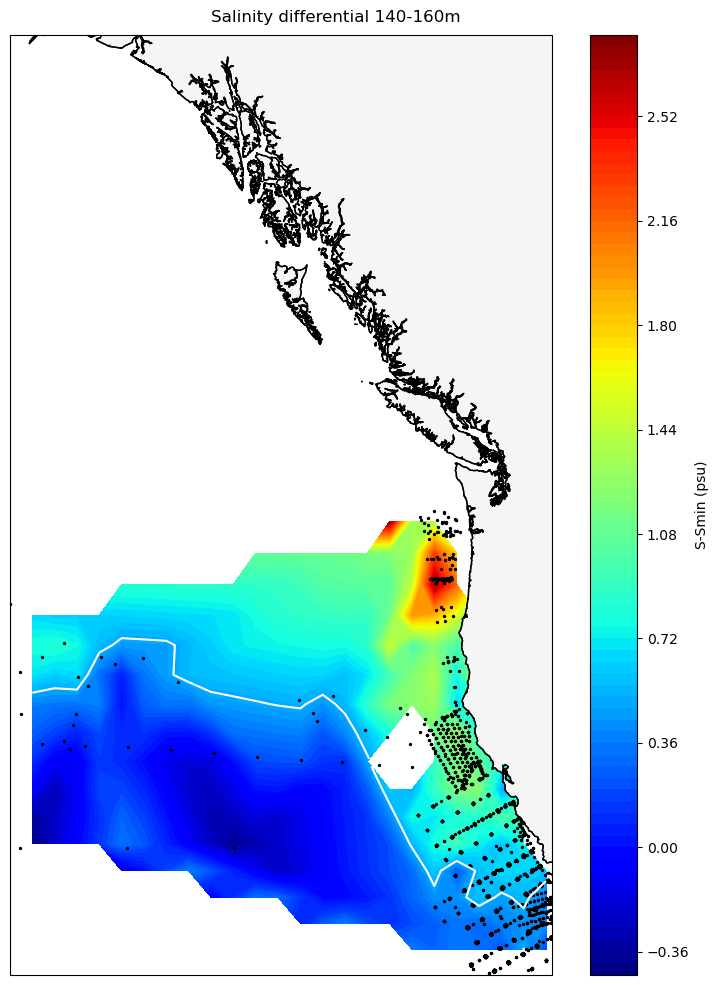

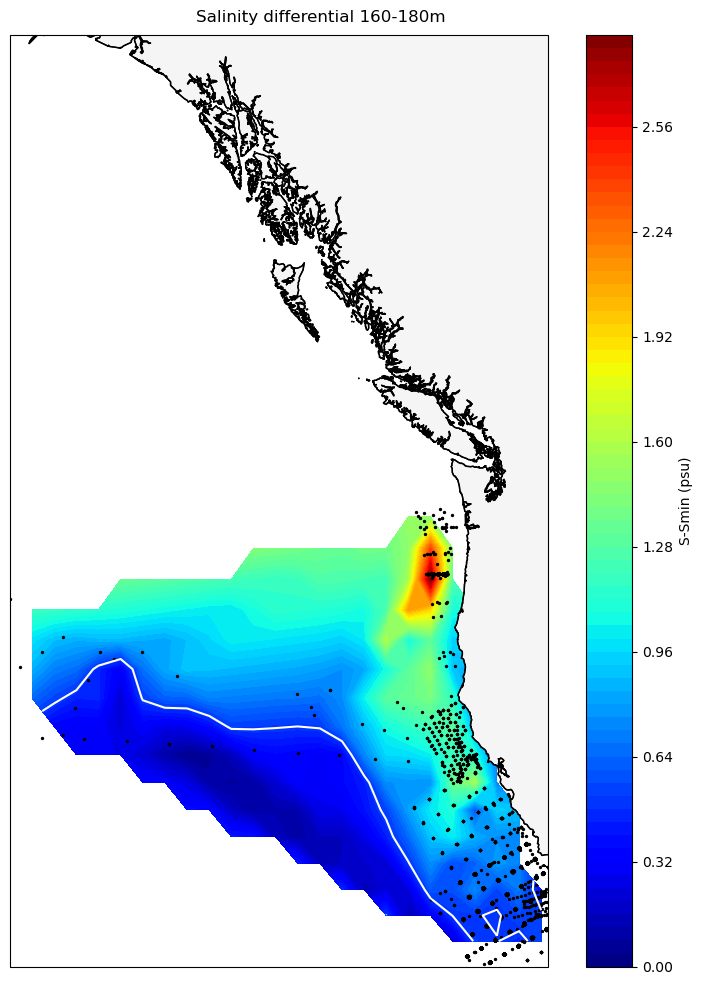

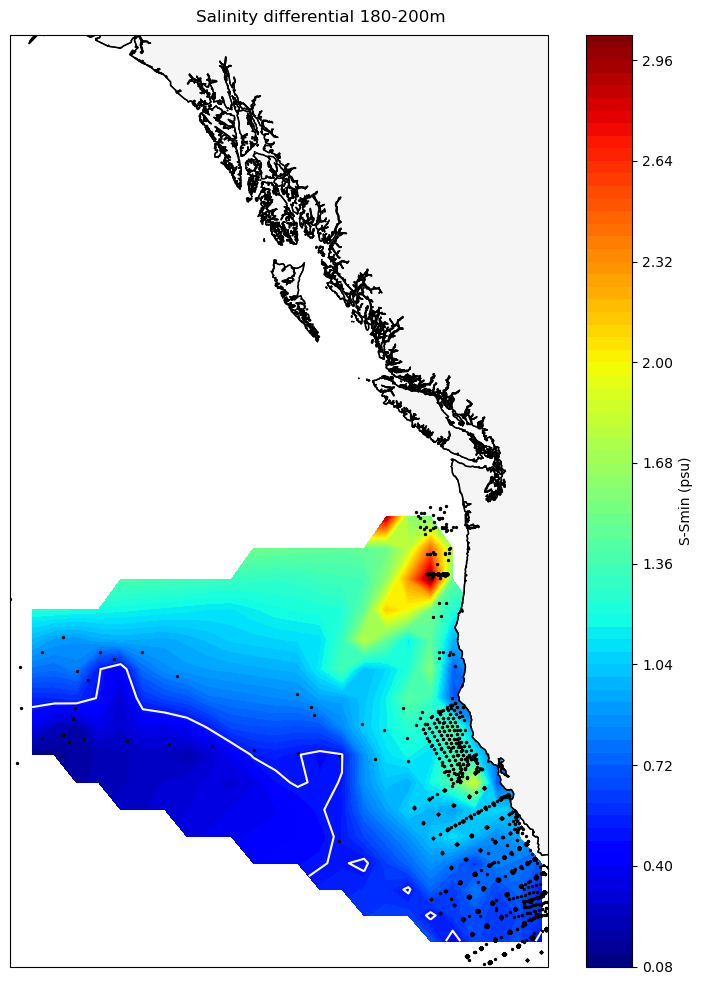

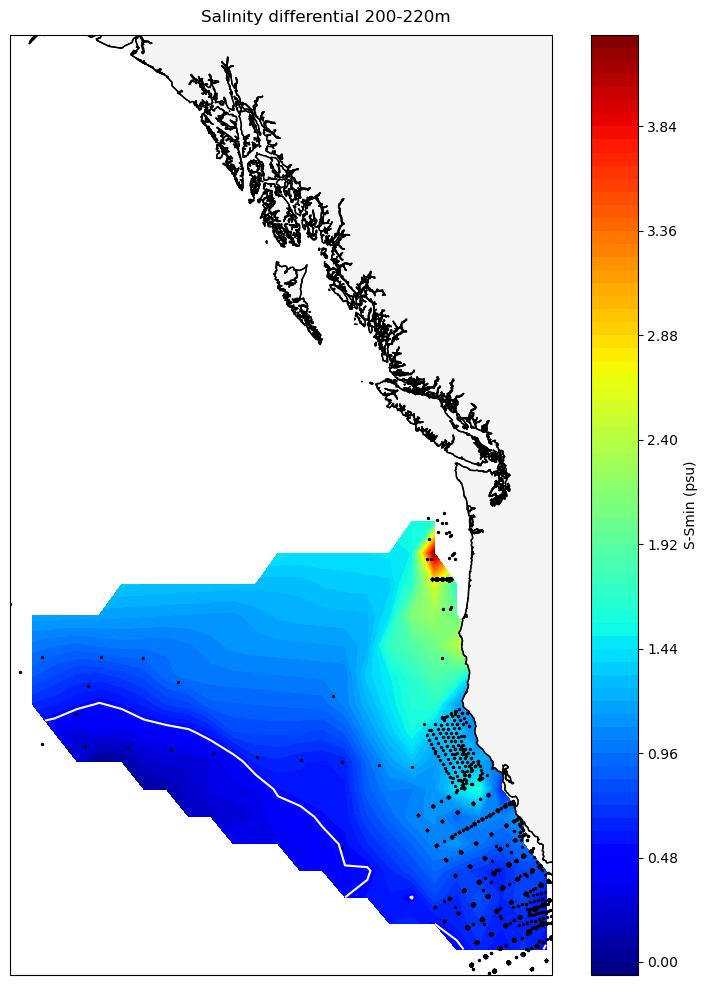

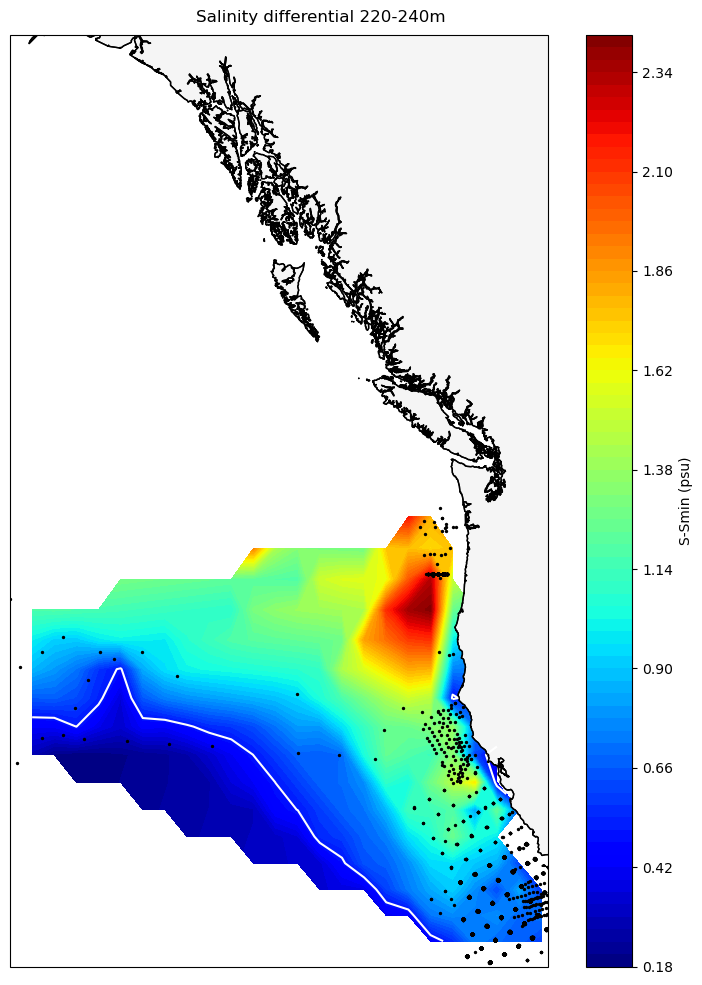

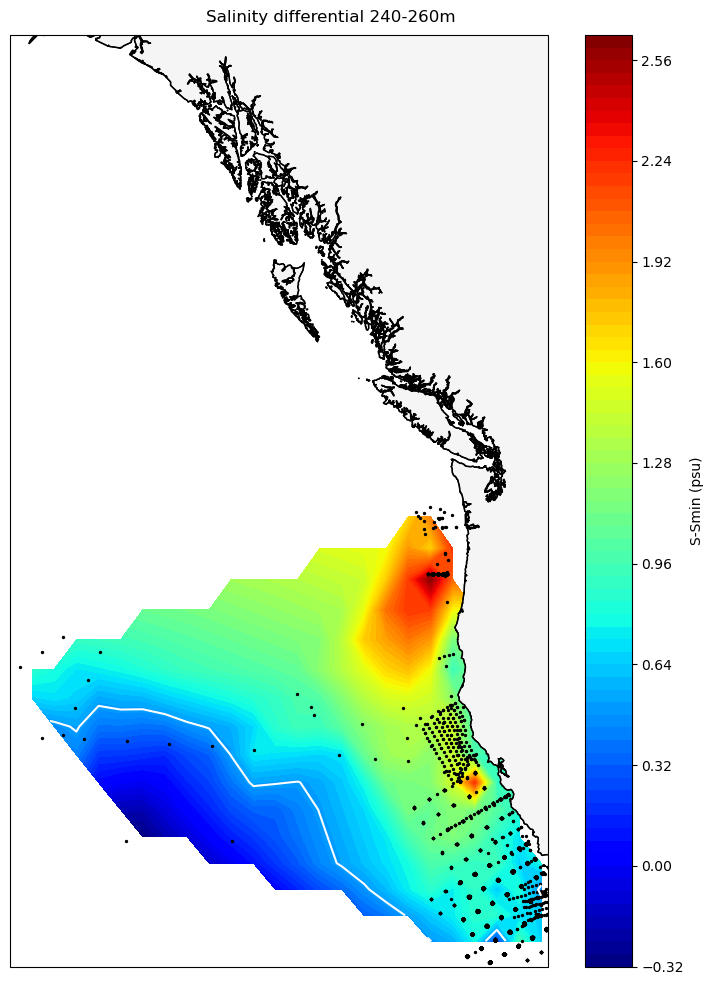

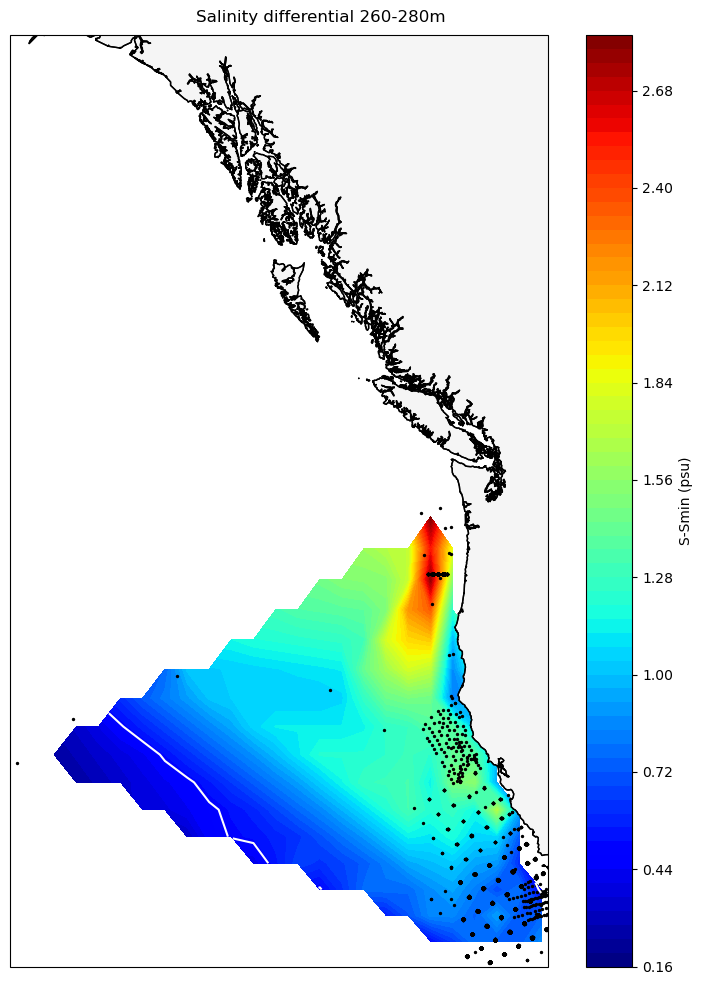

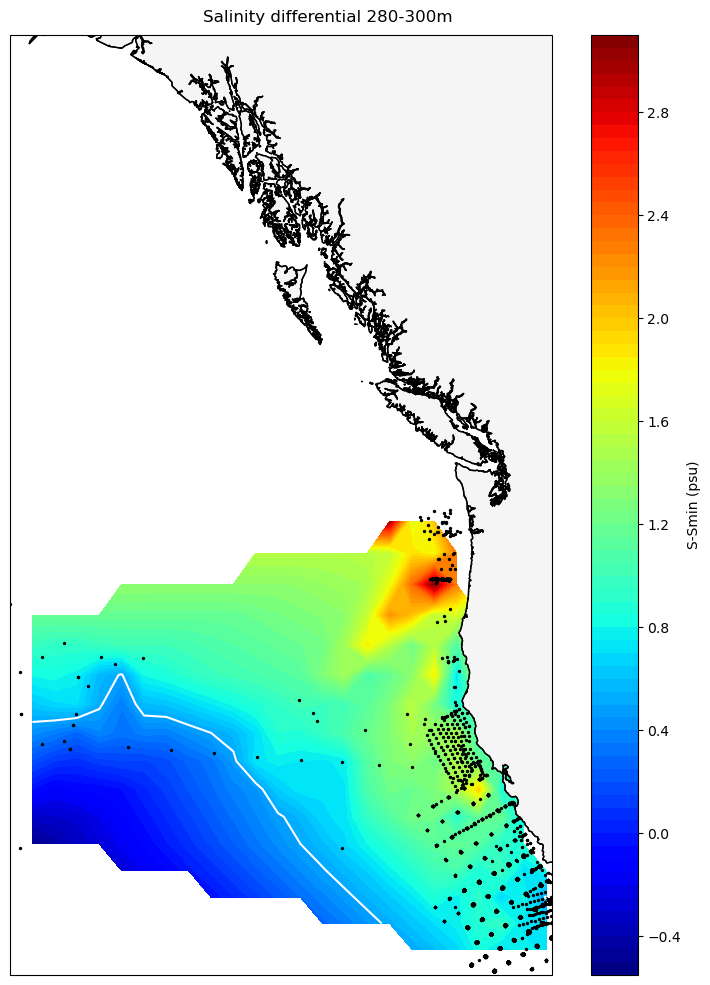

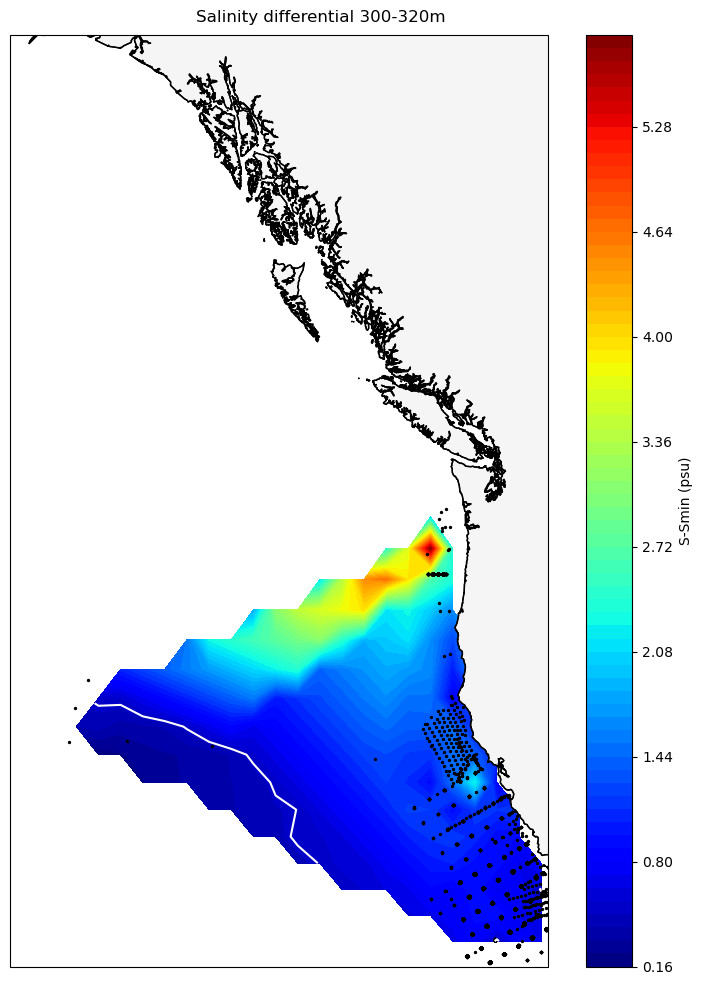

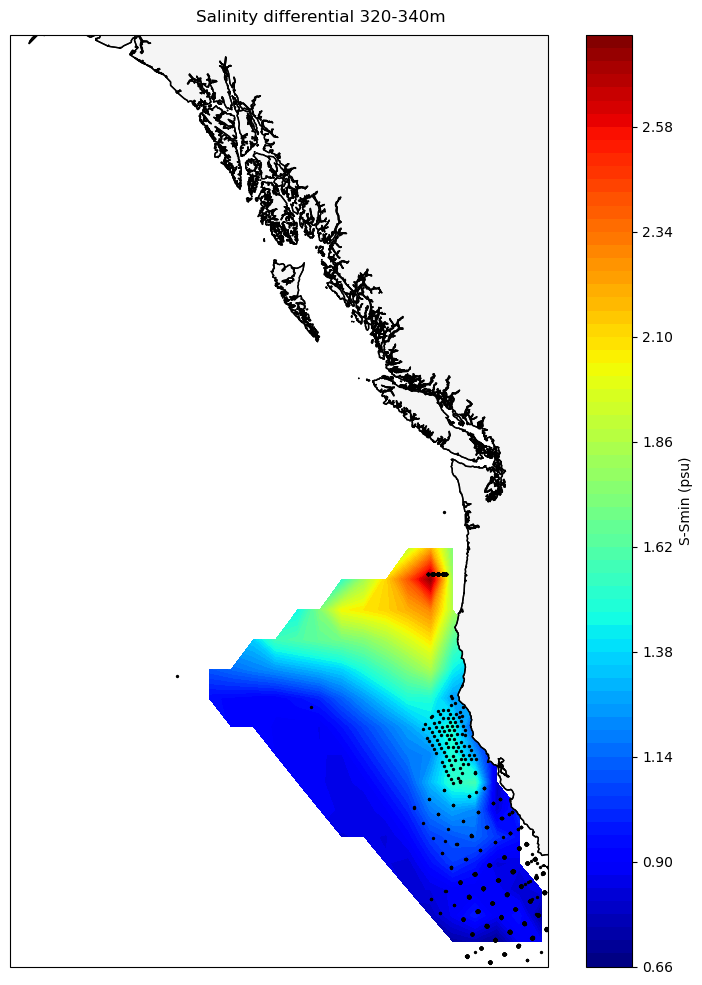

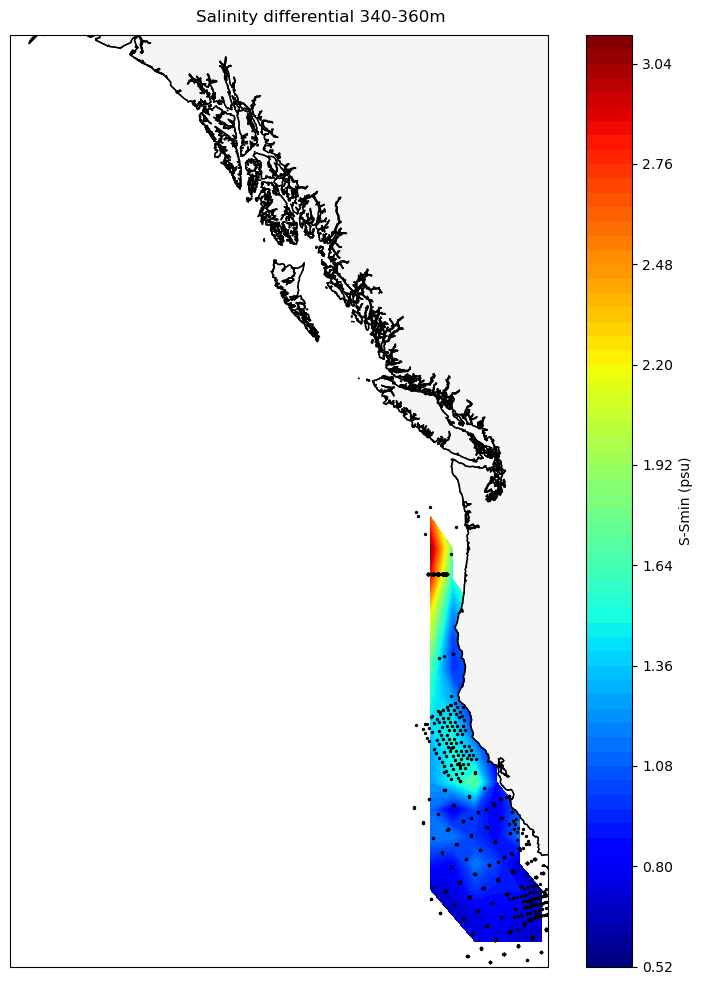

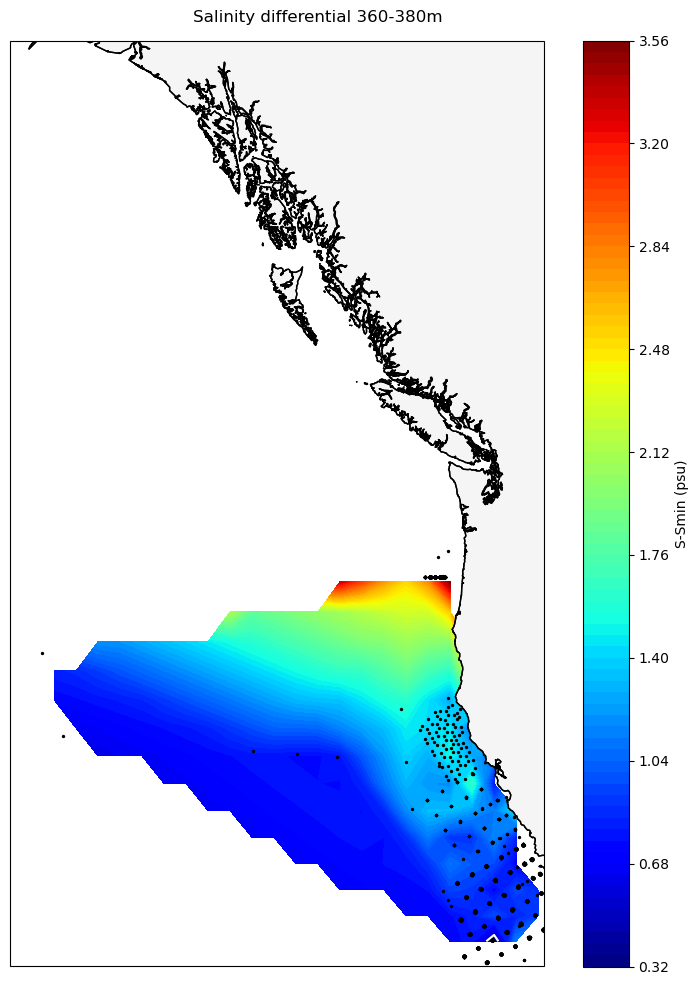

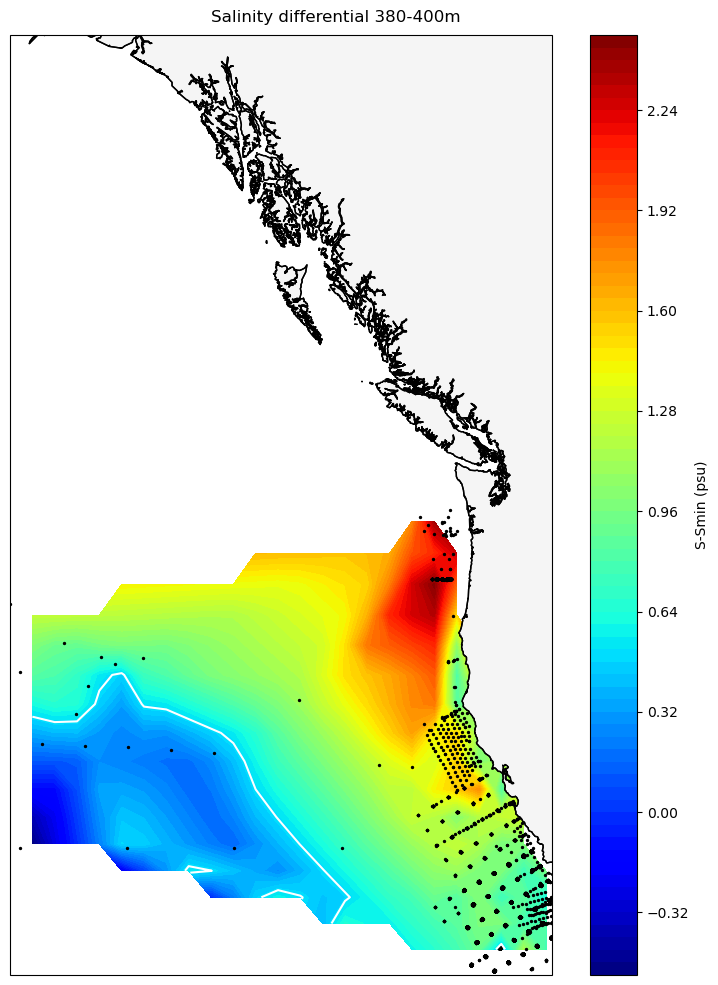

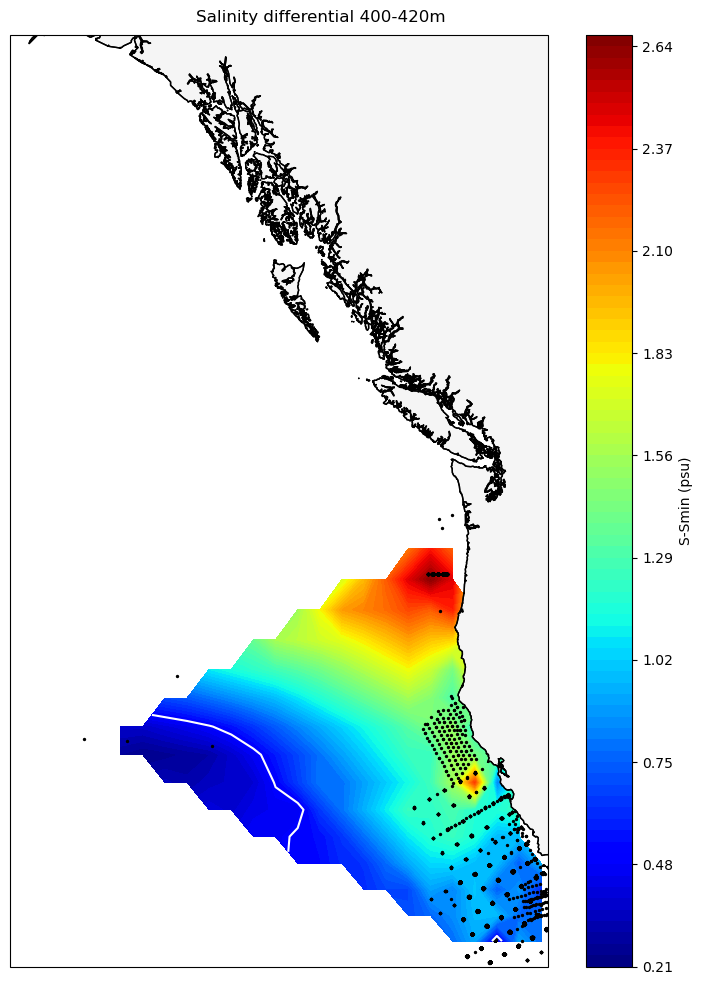

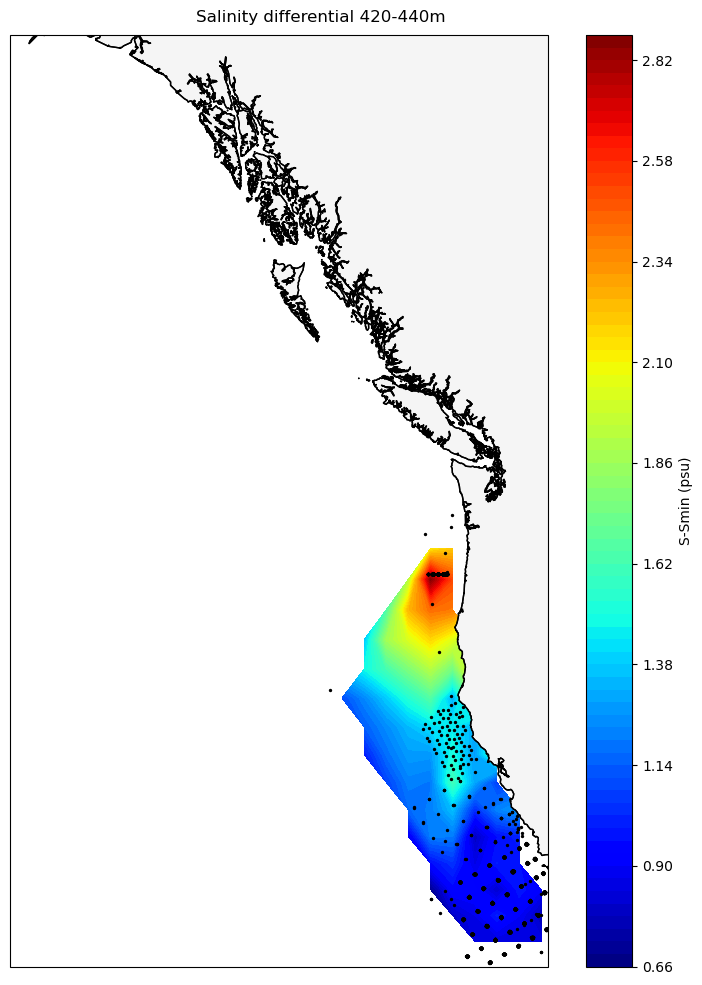

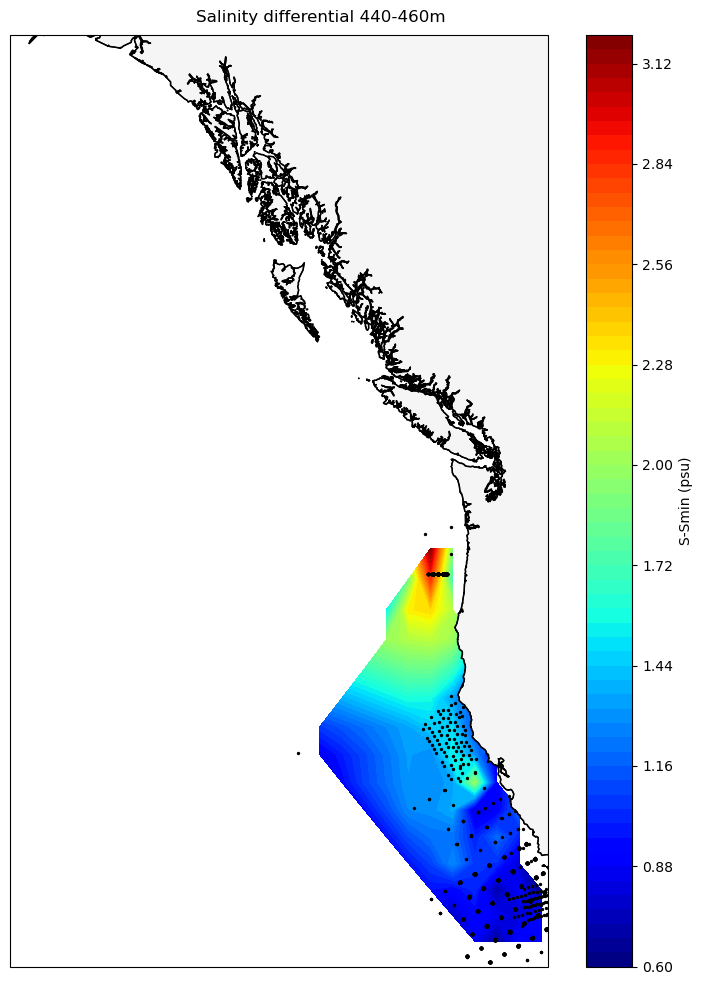

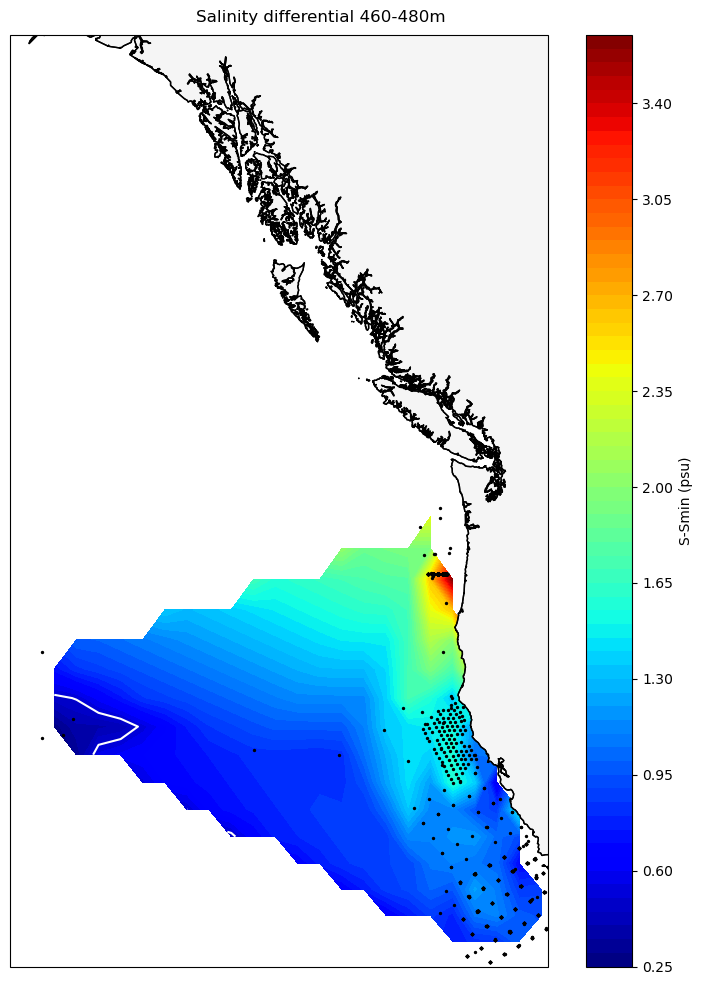

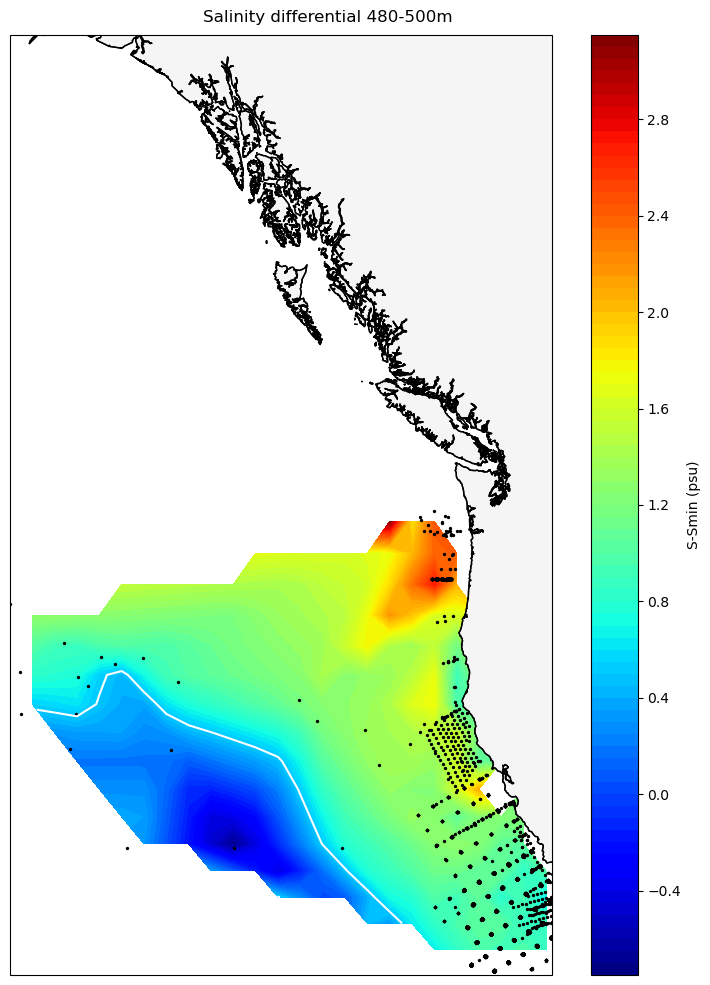

In [25]:
# Seperating California Current by Salinity field definition
S_threshold = 0.5
max_lat = 47

# Selecting data
mask = ((obs['current'] == '')
        & (obs['latitude (degrees_north)'] < max_lat))

cc_obs = obs[mask]

cc_obs['cast_id'] = cc_obs.groupby(['time', "longitude (degrees_east)", "latitude (degrees_north)"]).ngroup()
cc_obs.sort_values(by=['cast_id', 'depth (m)'], inplace=True)
cc_obs['is_cast'] = cc_obs['cast_id'].duplicated(keep=False)

smin = (
    cc_obs[cc_obs['is_cast']]
    .sort_values('depth (m)')
    .groupby('cast_id', as_index=False)
    .first()[['cast_id', 'salinity (psu)']]
    .rename(columns={'salinity (psu)': 'Smin'})
)

cc_obs = cc_obs.merge(smin, on='cast_id', how='left')
cc_obs['S-Smin'] = cc_obs['salinity (psu)'] - cc_obs['Smin']
cc_obs.loc[~cc_obs['is_cast'], 'S-Smin'] = pd.NA


thres_list = [1, 20] + list(range(40, 501, 20))
xlim, ylim = [-145.5, -120.2], [30, 60]

for i in range(len(thres_list)-1):
    up_thres = thres_list[i]
    low_thres = thres_list[i+1]
    depth_mask = ((cc_obs['depth (m)'] >= up_thres) & (cc_obs['depth (m)'] <= low_thres) & (cc_obs['is_cast']))
    x = cc_obs['longitude (degrees_east)'][depth_mask]
    y = cc_obs['latitude (degrees_north)'][depth_mask] 
    z = cc_obs['S-Smin'][depth_mask]  # scalar field 

    xext = xlim[1]-xlim[0]
    yext = ylim[1]-ylim[0]
    
    xi = np.linspace(-145.5, -120.5, 25)
    yi = np.linspace(30, 60, 30)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((x, y), z, (xi, yi), method='linear')
    
    fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
    
    # Make plot area
    ax.set_extent(xlim + ylim)
    
    # Draw coastline
    ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
    ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))
    
    cp = ax.contourf(xi, yi, zi, levels=80, cmap='jet', transform=crs.PlateCarree())
    ax.contour(xi, yi, zi, levels=[0.5], colors='w', transform=crs.PlateCarree())
    ax.scatter(x, y, s=2, c='k', transform=crs.PlateCarree())
    
    fig.colorbar(cp, label='S-Smin (psu)')
    ax.set_xlabel('Longitude (degE)')
    ax.set_ylabel('Latitude (degN)')
    plt.suptitle(f'Salinity differential {up_thres}-{low_thres}m')
    plt.tight_layout()

(27.0, 36.0)

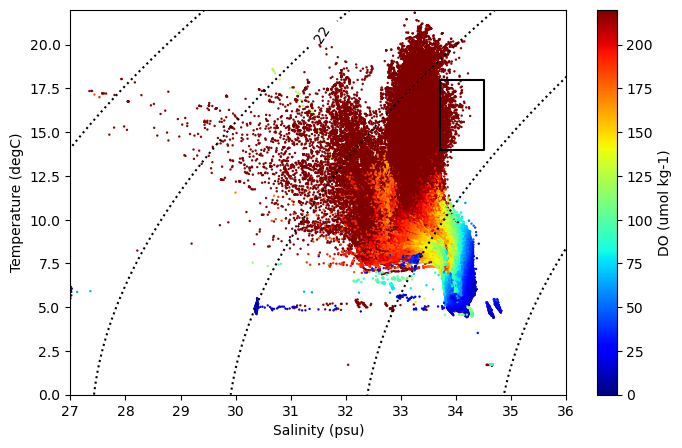

In [26]:
# T-S diagram of CC waters

# Setting up our grid and density contours
Temp = np.arange(0, 25, 0.2)
Sal = np.arange(18, 40, 0.4)
X,Y = np.meshgrid(Sal, Temp)
densZ = psu_tools.calculate_density(Y,X)-1000

fig, ax = plt.subplots(figsize=(8, 5))

cs = ax.contour(X,Y, densZ, levels=12, colors='k', linestyles='dotted')
ax.clabel(cs, cs.levels, fontsize=10)

sc = ax.scatter(cc_obs['salinity (psu)'], cc_obs['temperature (degC)'], s=0.5, c=cc_obs['DO (umol kg-1)'], cmap='jet', alpha=1, vmin=0, vmax=220)
cbar = fig.colorbar(sc, ax=ax, orientation='vertical', label='DO (umol kg-1)')

cc_square = np.array([[33.7, 14],
                     [33.7, 18],
                     [34.5, 18],
                     [34.5, 14],
                     [33.7, 14]])
ax.plot(cc_square[:,0], cc_square[:,1], c='k')
ax.set_xlabel('Salinity (psu)')
ax.set_ylabel('Temperature (degC)')
ax.set_ylim([0,22])
ax.set_xlim([27,36])

In [27]:
# Definition of CC based on Isopycnal and geography
def haversine(lat1, lon1, lat2, lon2):
    """
    Computes great-circle distance between two points on Earth (in km).
    """
    R = 6371.0  # Earth radius in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


def is_offshore100(lat, lon, coastline_geom, low_threshold_km=100, up_threshold_km=1000):
    point = Point(lon, lat)
    
    # Get nearest point on coastline boundary
    boundary = coastline_geom.boundary
    nearest_point = boundary.interpolate(boundary.project(point))
    
    # Use Haversine instead of geopy
    dist_km = haversine(lat, lon, nearest_point.y, nearest_point.x)
    return (dist_km > low_threshold_km) & (dist_km < up_threshold_km)

max_lat = 50
max_depth = 100

coastline = gpd.read_file('/ocean/ghoeven/MOAD/Data/ne_110m_land.shp')

# Define bounding box for area
bbox = box(-145.5, 30, -120.2, 60)  # lon_min, lat_min, lon_max, lat_max

# Clip the coastline to the bounding box
coastline_clipped = coastline[coastline.intersects(bbox)]
coastline_union = unary_union(coastline_clipped.geometry)

obs_copy = obs
obs_copy['is_offshore100'] = obs.apply(lambda row: is_offshore100(row['latitude (degrees_north)'],row['longitude (degrees_east)'],coastline_union), axis=1)

# Selecting data
mask = ((obs['current'] == '')
       & (obs['latitude (degrees_north)'] < max_lat) # Ouad et al
       & (obs['density (kg m-3)'] <= 26.3) # Itoh & Rudnick 2017
       # & (obs['density (kg m-3)'] <= 25.5) # Kurczyn et al 2019
       # & (obs['density (kg m-3)'] >= 24.5) # Kurczyn et al 2019
       # & (obs['depth (m)'] <= 100) # Kurczyn et al 2019
       & (obs_copy['is_offshore100'])) # Ouad et al

obs.loc[mask, 'current'] = 'CC'

cc_obs = obs[obs['current'] == 'CC']

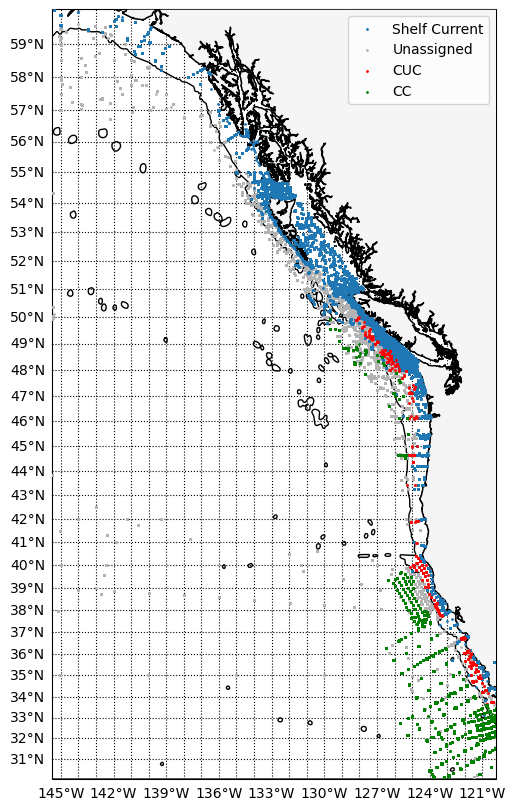

In [28]:
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=5))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=1))

# Add gridlines
xlocs, ylocs = [np.arange(np.floor(l[0]), np.ceil(l[1])+1) for l in [xlim, ylim]]
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs, zorder=4)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.top_labels, gl.right_labels = False, False

# and bathymetry
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=1))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'Shelf_Current'],obs['latitude (degrees_north)'][obs.current == 'Shelf_Current'], transform=crs.PlateCarree(),s=1,zorder=6,label='Shelf Current')
ax.scatter(obs['longitude (degrees_east)'][obs.current == ''],obs['latitude (degrees_north)'][obs.current == ''], c='0.7', transform=crs.PlateCarree(),s=1,zorder=5,label='Unassigned')
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'CUC'],obs['latitude (degrees_north)'][obs.current == 'CUC'], c='r', transform=crs.PlateCarree(),s=1,zorder=6,label='CUC')
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'CC'],obs['latitude (degrees_north)'][obs.current == 'CC'], c='g', transform=crs.PlateCarree(),s=1,zorder=6,label='CC')



ax.legend()

(30.0, 36.0)

/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


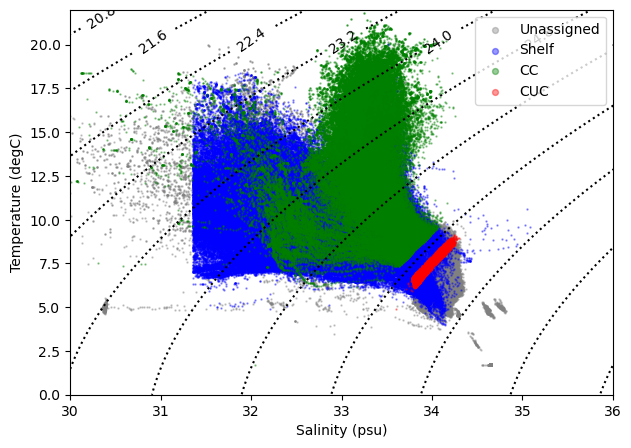

In [29]:
# T-S diagram of currents

# Setting up our grid and density contours
Temp = np.arange(0, 23, 0.2)
Sal = np.arange(30, 38, 0.4)
X,Y = np.meshgrid(Sal, Temp)
densZ = psu_tools.calculate_density(Y,X)-1000

fig, ax = plt.subplots(figsize=(7, 5))

cs = ax.contour(X,Y, densZ, levels=12, colors='k', linestyles='dotted')
ax.clabel(cs, cs.levels, fontsize=10)

ax.scatter(obs['salinity (psu)'][obs.current == ''], obs['temperature (degC)'][obs.current == ''], s=0.5, c='grey', label='Unassigned', alpha=0.4)
ax.scatter(obs['salinity (psu)'][obs.current == 'Shelf_Current'], obs['temperature (degC)'][obs.current == 'Shelf_Current'], s=0.5, c='b', label='Shelf', alpha=0.4)
ax.scatter(cc_obs['salinity (psu)'], cc_obs['temperature (degC)'], s=0.5, c='g', label='CC', alpha=0.4)
ax.scatter(obs_cuc['salinity (psu)'], obs_cuc['temperature (degC)'], s=0.5, c='r', label='CUC', alpha=0.4)

cc_square = np.array([[33.7, 14],
                     [33.7, 18],
                     [34.5, 18],
                     [34.5, 14],
                     [33.7, 14]])
# ax.plot(cc_square[:,0], cc_square[:,1], c='k', label='CC box?')
plt.legend(markerscale=6)
ax.set_xlabel('Salinity (psu)')
ax.set_ylabel('Temperature (degC)')
ax.set_ylim([0,22])
ax.set_xlim([30,36])

In [30]:
obs.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'time', 'longitude (degrees_east)',
       'latitude (degrees_north)', 'depth (m)', 'pressure (dbar)',
       'temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Co (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)',
       'Mn (nmol kg-1)', 'Ni (nmol kg-1)', 'Zn (nmol kg-1)', 'source',
       'Nstar (umol kg-1)', 'spice', 'current', 'geometry', 'location',
       'month', 'year', 'salinity (psu)', 'density (kg m-3)', 'is_offshore100',
       'TA-DIC (uM)'],
      dtype='object')

In [31]:
obs['TA-DIC (uM)'] = obs['TA (uM)'] -  obs['DIC (uM)']

In [32]:
# OUTPATH = '/ocean/ghoeven/MOAD/Data/PNWCurrent_obs.csv'

# obs.to_csv(OUTPATH)